In [393]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy

%matplotlib inline
plt.style.use('ggplot')
np.random.seed(1)

# Datasets
We have two datasets, mat1 and mat2, both consisting of 2 dimensional samples (700, 1400 respectively). We plot these on an 2D plot to examine our data before clustering.

In [394]:
mat1 = scipy.io.loadmat('data1.mat')['X']
mat2 = scipy.io.loadmat('data2.mat')['X']

In [395]:
mat1.shape, mat2.shape

((2, 700), (2, 1400))

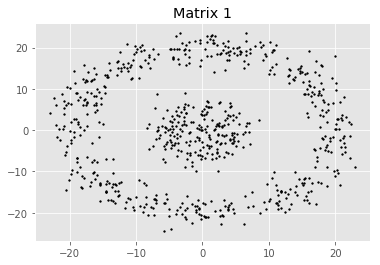

In [396]:
plt.scatter(mat1[0], mat1[1], c='black', s=3)
plt.title('Matrix 1')
plt.show()

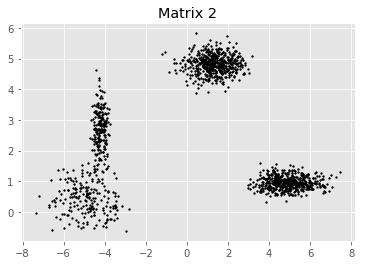

In [397]:
plt.scatter(mat2[0], mat2[1], c='black', s=3)
plt.title('Matrix 2')
plt.show()

# Problem 1, K-Means Clustering
We now try out K-means. K-means can only separate clusters by linear boundaries, so we expect mat1 to be unseparable by KMeans.

In [398]:
def dist(a, b, ax=1):
    """ Euclidean distance """
    return np.linalg.norm(a-b, axis=ax)

In [399]:
import copy

def kmeans(X, k):
    C_x = np.random.uniform(0, np.max(X[0]), size=k)
    C_y = np.random.uniform(0, np.max(X[1]), size=k)
    C = np.array(list(zip(C_x, C_y)), dtype=np.float32)

    C_old = np.zeros(C.shape)
    clusters = np.zeros(X.shape[1])
    error = dist(C, C_old, None)
    
    flag = True
    
    while error != 0:
        for i in range(X.shape[1]):
            distances = dist((X[0][i], X[1][i]), C)
            if numpy.isnan(distances).any() and flag:
                flag = False
                print(distances)
                print("Coords: ")
                print(X[0][i], X[1][i])
                print("C: ")
                print(C)
            cluster = np.argmin(distances)
            clusters[i] = cluster
        C_old = copy.deepcopy(C)
        for i in range(k):
            points = np.array([(X[0][j], X[1][j]) for j in range(X.shape[1]) if clusters[j] == i])
            if len(points) == 0:
                C[i] = 0
            else:
                C[i] = np.mean(points, axis=0)
        error = dist(C, C_old, None)
    
    return clusters

In [400]:
def plot_clusters(X, clusters, k, title="Title here"):
    symbols = ['x', 'o', '^', '.', '1', '2', '3', '4']
    fig, ax = plt.subplots()
    for i in range(k):
        points = np.array([(X[0][j], X[1][j]) for j in range(X.shape[1]) if clusters[j] == i])
        if len(points) != 0:
            ax.scatter(points[:, 0], points[:, 1], s=40, marker=symbols[i])
    plt.title(title)

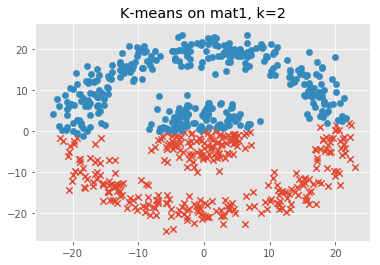

In [401]:
clusters = kmeans(mat1, k=2)
plot_clusters(mat1, clusters, 2, "K-means on mat1, k=2")

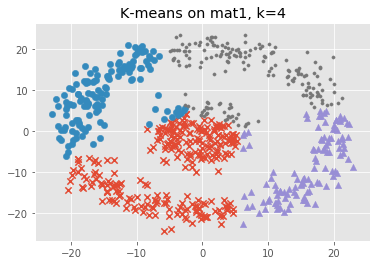

In [402]:
clusters = kmeans(mat1, k=4)
plot_clusters(mat1, clusters, 4, "K-means on mat1, k=4")

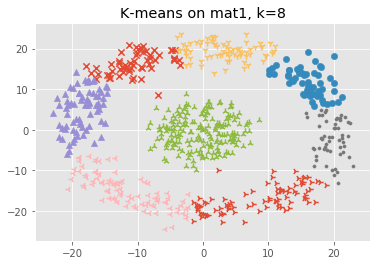

In [403]:
clusters = kmeans(mat1, k=8)
plot_clusters(mat1, clusters, 8, "K-means on mat1, k=8")

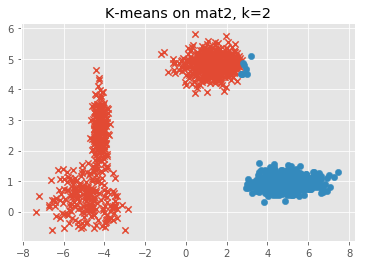

In [404]:
clusters = kmeans(mat2, k=2)
plot_clusters(mat2, clusters, 2, "K-means on mat2, k=2")

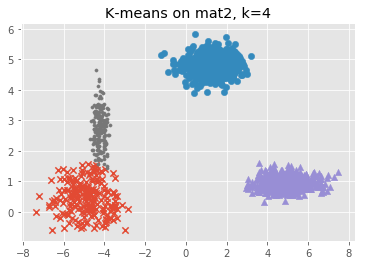

In [405]:
clusters = kmeans(mat2, k=4)
plot_clusters(mat2, clusters, 4, "K-means on mat2, k=4")

By inspection, we see that K-means clustering with 4 clusters successfully separates our mat2 data.

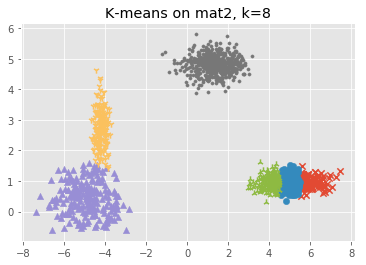

In [406]:
clusters = kmeans(mat2, k=8)
plot_clusters(mat2, clusters, 8, "K-means on mat2, k=8")

# Problem 2, Spectral Clustering
Spectral clustering, or affinity-based clustering, can handle non linearly separable classes, so it may work on mat1.

In [407]:
def similarity(a, b):
    return np.exp(-(abs(a-b)**2) / 10)

In [693]:
def spectral_clustering(affinity, k):
    def laplacian(A):
        D = np.zeros(A.shape)
        w = np.sum(A, axis=0)
        D.flat[::len(w) + 1] = w ** (-0.5)
        return D.dot(A).dot(D)
    L = laplacian(affinity)
    _, eigvec = scipy.sparse.linalg.eigs(L, k)
    X = eigvec.real
    rows_norm = np.linalg.norm(X, axis=1, ord=2)
    labels = kmeans((X.T / rows_norm), k)
    return labels

In [1133]:
def compute_affinity(X):
    def squared_exponential(x, y, sig=0.8, sig2=1):
        """ Models smooth functions
        
        Function from previous spectral clustering project from tut """
        norm = numpy.linalg.norm(x - y)
        dist = norm * norm
        return numpy.exp(- dist / (2 * sig * sig2))
    
    N = X.shape[0]
    res = np.zeros((N, N))
    sig = []
    for i in range(N):
        dists = []
        for j in range(N):
            dists.append(np.linalg.norm(X[i] - X[j]))
        dists.sort()
        sig.append(np.mean(dists[:5]))

    for i in range(N):
        for j in range(N):
            res[i][j] = squared_exponential(X[i], X[j], sig[i], sig[j])
    return res

In [555]:
affinity1 = compute_affinity(mat1.T)

In [556]:
affinity1

array([[1.00000000e+000, 9.07373112e-068, 2.13806994e-067, ...,
        3.75536786e-156, 6.45797708e-058, 3.80635345e-104],
       [9.07373112e-068, 1.00000000e+000, 1.28165649e-010, ...,
        7.78220139e-177, 5.78066276e-003, 1.68477241e-160],
       [2.13806994e-067, 1.28165649e-010, 1.00000000e+000, ...,
        5.33745514e-118, 5.21226973e-015, 3.01382806e-099],
       ...,
       [3.75536786e-156, 7.78220139e-177, 5.33745514e-118, ...,
        1.00000000e+000, 4.24887021e-210, 3.97603155e-019],
       [6.45797708e-058, 5.78066276e-003, 5.21226973e-015, ...,
        4.24887021e-210, 1.00000000e+000, 1.23857683e-179],
       [3.80635345e-104, 1.68477241e-160, 3.01382806e-099, ...,
        3.97603155e-019, 1.23857683e-179, 1.00000000e+000]])

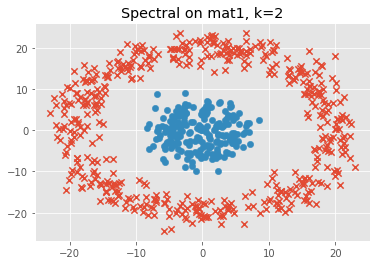

In [697]:
k1 = spectral_clustering(affinity1, 2)
plot_clusters(mat1, k1, 2, "Spectral on mat1, k=2")

By inspection, we see that spectral clustering with 2 clusters successfully separates our mat1 data

In [521]:
s1, s2 = mat1.T[[True if y==1 else False for y in Y]], mat1.T[[True if y==0 else False for y in Y]]
affinity1_1 = compute_affinity(s1)
affinity1_2 = compute_affinity(s2)

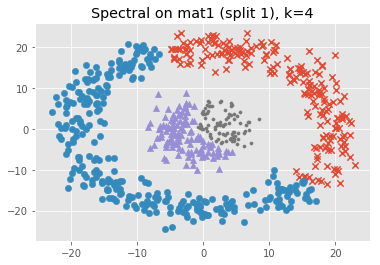

In [522]:
s1_labels = spectral_clustering(affinity1_1, 2)
s2_labels = spectral_clustering(affinity1_2, 2)

k2_labels = np.append(s1_labels, s2_labels+2)
k2 = np.concatenate((s1, s2))
plot_clusters(k2.T, k2_labels, 4, "Spectral on mat1 (split 1), k=4")

In [528]:
s3, s4, s5, s6 = k2[[True if y==0 else False for y in k2_labels]], k2[[True if y==1 else False for y in k2_labels]], k2[[True if y==2 else False for y in k2_labels]], k2[[True if y==3 else False for y in k2_labels]]
affinity1_3 = compute_affinity(s3)
affinity1_4 = compute_affinity(s4)
affinity1_5 = compute_affinity(s5)
affinity1_6 = compute_affinity(s6)

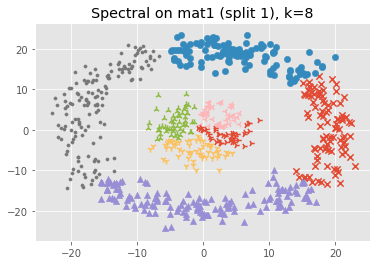

In [535]:
s3_labels = spectral_clustering(affinity1_3, 2)
s4_labels = spectral_clustering(affinity1_4, 2)
s5_labels = spectral_clustering(affinity1_5, 2)
s6_labels = spectral_clustering(affinity1_6, 2)

k8_labels = np.concatenate((s3_labels, s4_labels+2, s5_labels+4, s6_labels+6))
k8 = np.concatenate((s3, s4, s5, s6))
plot_clusters(k8.T, k8_labels, 8, "Spectral on mat1 (split 2), k=8")

#### Spectral Wrapper Functions

In [592]:
def spectral(M):
    affinity = compute_affinity(M.T)
    return spectral_clustering(affinity, 2), M

def spectral4(M):
    Y, X = spectral(M)
    s1, s2 = M.T[[True if y==1 else False for y in Y]], X.T[[True if y==0 else False for y in Y]]
    affinity1_1 = compute_affinity(s1)
    affinity1_2 = compute_affinity(s2)
    s1_labels = spectral_clustering(affinity1_1, 2)
    s2_labels = spectral_clustering(affinity1_2, 2)
    k2_labels = np.append(s1_labels, s2_labels+2)
    k2 = np.concatenate((s1, s2))
    return Y, X, k2_labels, k2

def spectral8(M):
    Y1, X1, Y, X = spectral4(M)
    s3, s4, s5, s6 = X[[True if y==0 else False for y in Y]], X[[True if y==1 else False for y in Y]], X[[True if y==2 else False for y in Y]], X[[True if y==3 else False for y in Y]]
    affinity1_3 = compute_affinity(s3)
    affinity1_4 = compute_affinity(s4)
    affinity1_5 = compute_affinity(s5)
    affinity1_6 = compute_affinity(s6)
    
    s3_labels = spectral_clustering(affinity1_3, 2)
    s4_labels = spectral_clustering(affinity1_4, 2)
    s5_labels = spectral_clustering(affinity1_5, 2)
    s6_labels = spectral_clustering(affinity1_6, 2)

    k8_labels = np.concatenate((s3_labels, s4_labels+2, s5_labels+4, s6_labels+6))
    k8 = np.concatenate((s3, s4, s5, s6))
    return Y1, X1, Y, X, k8_labels, k8

In [593]:
Y1, X1, Y4, X4, Y8, X8 = spectral8(mat2)

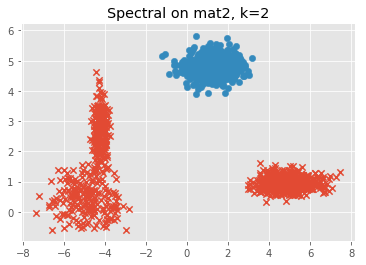

In [595]:
plot_clusters(X1, Y1, 2, "Spectral on mat2, k=2")

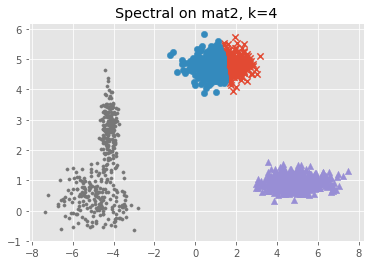

In [598]:
plot_clusters(X4.T, Y4, 4, "Spectral on mat2, k=4")

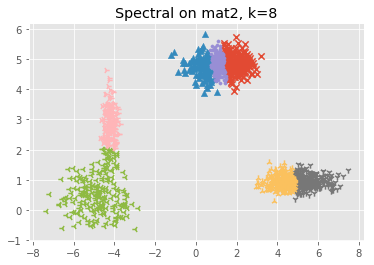

In [600]:
plot_clusters(X8.T, Y8, 8, "Spectral on mat2, k=8")

# Problem 3: Comparison with Cost Functions

In [677]:
def sum_squared_error(classes):
    Je = 0
    for cl in classes:
        mean = np.mean(cl, axis=0)
        for x in cl:
            Je += np.inner(x-mean, x-mean)
    return Je

In [724]:
def determinant(classes):
    S_W = 0
    for cl in classes:
        mean = np.mean(cl, axis=0)
        S_i = 0
        for i in range(np.array(cl).shape[0]):
            S_i += np.outer(cl[:][i]-mean, cl[:][i]-mean)
        S_W += S_i
    return np.linalg.det(S_W)

In [751]:
import itertools as it

def min_variance(classes):
    Je = 0
    for cl in classes:
        si = np.sum([np.inner(x-y,x-y) for x,y in it.combinations(cl, 2)])
        Je += si/np.array(cl).shape[0]
    return Je

In [737]:
def transform(X, Y, n):
    arr = [[] for i in range(n)]
    for i in range(len(Y)):
        arr[int(Y[i])].append(X[i])
    return arr

/usr/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [744]:
M2C2KMeans = transform(mat2.T, kmeans(mat2, k=2), 2)
M2C4KMeans = transform(mat2.T, kmeans(mat2, k=4), 4)
M2C8KMeans = transform(mat2.T, kmeans(mat2, k=8), 8)
M2C2Spectral = transform(X1.T, Y1, 2)
M2C4Spectral = transform(X4, Y4, 4)
M2C8Spectral = transform(X8, Y8, 8)

M1C2KMeans = transform(mat1.T, kmeans(mat1, k=2), 2)
M1C4KMeans = transform(mat1.T, kmeans(mat1, k=4), 4)
M1C8KMeans = transform(mat1.T, kmeans(mat1, k=8), 8)
M1C2Spectral = transform(mat1.T, k1, 2)
M1C4Spectral = transform(k2, k2_labels, 4)
M1C8Spectral = transform(k8, k8_labels, 8)

In [743]:
e1 = sum_squared_error(M2C2KMeans)
e2 = sum_squared_error(M2C4KMeans)
e3 = sum_squared_error(M2C8KMeans)
e4 = sum_squared_error(M2C2Spectral)
e5 = sum_squared_error(M2C4Spectral)
e6 = sum_squared_error(M2C8Spectral)

e7 = sum_squared_error(M1C2KMeans)
e8 = sum_squared_error(M1C4KMeans)
e9 = sum_squared_error(M1C8KMeans)
e10 = sum_squared_error(M1C2Spectral)
e11 = sum_squared_error(M1C4Spectral)
e12 = sum_squared_error(M1C8Spectral)

/usr/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Sum Squared Error

In [738]:
print("Sum Squared Error, Dataset 2")
print("C=2 | KMeans: " + str(e1) + " Spectral: " + str(e4))
print("C=4 | KMeans: " + str(e2) + " Spectral: " + str(e5))
print("C=8 | KMeans: " + str(e3) + " Spectral: " + str(e6))

Sum Squared Error, Dataset 2
C=2 | KMeans: 11523.462641572416 Spectral: 12980.544476534591
C=4 | KMeans: 1308.589852762342 Spectral: 1367.4907262152626
C=8 | KMeans: 1249.690428419723 Spectral: 556.4301312921771


In [739]:
print("Sum Squared Error, Dataset 1")
print("C=2 | KMeans: " + str(e7) + " Spectral: " + str(e10))
print("C=4 | KMeans: " + str(e8) + " Spectral: " + str(e11))
print("C=8 | KMeans: " + str(e9) + " Spectral: " + str(e12))

Sum Squared Error, Dataset 1
C=2 | KMeans: 131904.90415142267 Spectral: 207710.95870316675
C=4 | KMeans: 67243.97450008814 Spectral: 129584.95960087515
C=8 | KMeans: 20491.671457244076 Spectral: 44623.695784612944


#### Discussion
These results do not compare well with the visual observations given by the above clustering algorithms. When we increase the number of clusters, the numerical error obviously decreases. However, we see that dataset 1 (mat1) obviously has only 2 classes, so k=2 is the best (and is visually so, with the spectral clustering), but the numerical error decreases as we increase k. For dataset 2 which is linearly separable, KMeans and Spectral almost perform the same. This is not the case for dataset 1, where with K=2 Spectral successfully separates the clusters but KMeans does not. And yet, Spectral's sum squared error is 207710 > KMean's SSE of 139335.

### Determinant

In [745]:
e1 = determinant(M2C2KMeans)
e2 = determinant(M2C4KMeans)
e3 = determinant(M2C8KMeans)
e4 = determinant(M2C2Spectral)
e5 = determinant(M2C4Spectral)
e6 = determinant(M2C8Spectral)

e7 = determinant(M1C2KMeans)
e8 = determinant(M1C4KMeans)
e9 = determinant(M1C8KMeans)
e10 = determinant(M1C2Spectral)
e11 = determinant(M1C4Spectral)
e12 = determinant(M1C8Spectral)

/usr/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [746]:
print("Determinant, Dataset 2")
print("C=2 | KMeans: " + str(e1) + " Spectral: " + str(e4))
print("C=4 | KMeans: " + str(e2) + " Spectral: " + str(e5))
print("C=8 | KMeans: " + str(e3) + " Spectral: " + str(e6))

Determinant, Dataset 2
C=2 | KMeans: 8107128.413448382 Spectral: 26358947.80734672
C=4 | KMeans: 145456.4670150636 Spectral: 446531.7034244581
C=8 | KMeans: 84989.73206552764 Spectral: 72199.32401656003


In [747]:
print("Determinant, Dataset 1")
print("C=2 | KMeans: " + str(e7) + " Spectral: " + str(e10))
print("C=4 | KMeans: " + str(e8) + " Spectral: " + str(e11))
print("C=8 | KMeans: " + str(e9) + " Spectral: " + str(e12))

Determinant, Dataset 1
C=2 | KMeans: 3285283551.736198 Spectral: 10751492347.651451
C=4 | KMeans: 975897318.337423 Spectral: 2557848611.074802
C=8 | KMeans: 120141496.7612552 Spectral: 494209586.2569458


### Min Variance

In [753]:
e1 = min_variance(M2C2KMeans)
e2 = min_variance(M2C4KMeans)
e3 = min_variance(M2C8KMeans)
e4 = min_variance(M2C2Spectral)
e5 = min_variance(M2C4Spectral)
e6 = min_variance(M2C8Spectral)

e7 = min_variance(M1C2KMeans)
e8 = min_variance(M1C4KMeans)
e9 = min_variance(M1C8KMeans)
e10 = min_variance(M1C2Spectral)
e11 = min_variance(M1C4Spectral)
e12 = min_variance(M1C8Spectral)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


In [756]:
print("Min Variance, Dataset 2")
print("C=2 | KMeans: " + str(e1) + " Spectral: " + str(e4))
print("C=4 | KMeans: " + str(e2) + " Spectral: " + str(e5))
print("C=8 | KMeans: " + str(e3) + " Spectral: " + str(e6))

Min Variance, Dataset 2
C=2 | KMeans: 11523.46264157244 Spectral: 12980.544476534602
C=4 | KMeans: 955.5036139177143 Spectral: 1367.4907262152633
C=8 | KMeans: 637.8077128578185 Spectral: nan


In [757]:
print("Min Variance, Dataset 1")
print("C=2 | KMeans: " + str(e7) + " Spectral: " + str(e10))
print("C=4 | KMeans: " + str(e8) + " Spectral: " + str(e11))
print("C=8 | KMeans: " + str(e9) + " Spectral: " + str(e12))

Min Variance, Dataset 1
C=2 | KMeans: 131839.5046818803 Spectral: 207710.95870316686
C=4 | KMeans: 63969.713173109674 Spectral: 129584.9596008751
C=8 | KMeans: 22066.58996087212 Spectral: 44623.69578461293


#### Discussion
We also note that Min Variance and Sum Squared Error are equivalent in this case.

# Problem 4: Expectation Maximization
We use expectation maximization with gaussian assumption (gaussian mixture model) to find parameters (means, covariances, and priors) for the gaussian PDF. Once we converge (or in this case, run for 100 iterations), we use the last cluster result as our clustering.

This should be the slower of the three algorithms on this dataset without algorithmic optimization.

In [761]:
mat2.shape

(2, 1400)

In [781]:
for i in range(2,9):
    # find priors, means, and covariances
    print(i)

2
3
4
5
6
7
8


In [1081]:
from scipy.stats import multivariate_normal

def prob(val, mean, cov, prior):
    p = prior
    for i in range(len(val)):
        try:
            p *= multivariate_normal.pdf(val[i], mean[i], cov[i][i])
        except IndexError:
            p *= 1.0
    return p

### Part A: Expectation Maximization

In [1094]:
C_results = dict()

for C in [2,4,8]:
    # initial parameters
    means = np.array([np.random.uniform(-5,5,2) for i in range(C)])
    covs = np.array([np.eye(2) for i in range(C)])
    priors = np.array([1.0/c] * C)

    clusters = []
    for i in range(10):
        # evaluate most likely clusters for every point, given current parameters
        clusters[:] = []
        for i in range(mat2.shape[1]):
            point = mat2[0][i], mat2[1][i]
            cluster = np.argmax([prob(point, means[cl], covs[cl], priors[cl]) for cl in range(C)])
            clusters.append(cluster)

        # reestimate parameters given current clusters
        assignments = np.array([np.concatenate(np.argwhere(np.array(clusters)==i)) if i in clusters else np.array([]) for i in range(C)])
        populations = np.array([len(i) for i in assignments])
        ratios = populations / np.sum(populations)

        means = np.array([np.mean(np.squeeze(np.dstack((mat2[0][assignments[i]], mat2[1][assignments[i]]))), axis=0) if i in clusters else np.random.uniform(-5,5,2) for i in range(C)])
        covs = np.array([np.cov(np.squeeze(np.dstack((mat2[0][assignments[i]], mat2[1][assignments[i]]))).T) if i in clusters else np.eye(2) for i in range(C)])
        priors = np.array(ratios)
    
    # get final clusters
    for i in range(mat2.shape[1]):
        point = mat2[0][i], mat2[1][i]
        cluster = np.argmax([prob(point, means[cl], covs[cl], priors[cl]) for cl in range(C)])
        clusters.append(cluster)
    C_results[C] = clusters, means, covs, priors


We use 10 iterations instead of 100 because of computer heating issues, and because of reasonable convergence with 10 iterations.

### Part B: Clustering

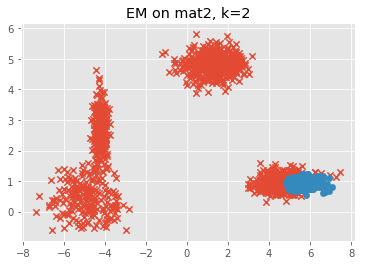

In [1095]:
plot_clusters(mat2, C_results[2][0], 2, "EM on mat2, k=2")

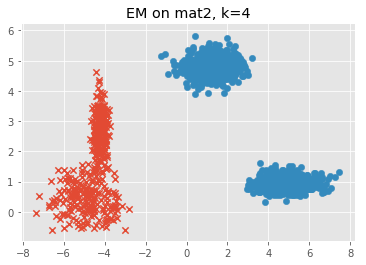

In [1096]:
plot_clusters(mat2, C_results[4][0], 4, "EM on mat2, k=4")

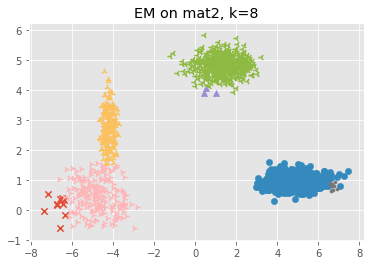

In [1097]:
plot_clusters(mat2, C_results[8][0], 8, "EM on mat2, k=8")

### Comparison with Cost Functions

In [1116]:
M2C2EM = transform(mat2.T, C_results[2][0][:1400], 2)
M2C4EM = transform(mat2.T, C_results[4][0][:1400], 4)
M2C8EM = transform(mat2.T, C_results[8][0][:1400], 8)

In [1130]:
e1 = sum_squared_error(M2C2KMeans)
e2 = sum_squared_error(M2C4KMeans)
e3 = sum_squared_error(M2C8KMeans)
e4 = sum_squared_error(M2C2Spectral)
e5 = sum_squared_error(M2C4Spectral)
e6 = sum_squared_error(M2C8Spectral)
e7 = sum_squared_error(M2C2EM)
e8 = sum_squared_error(M2C4EM)
e9 = sum_squared_error(M2C8EM)

/usr/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [1118]:
print("Sum Squared Error, Dataset 2")
print("C=2 | KMeans: " + str(e1) + " Spectral: " + str(e4) + " EM: " + str(e7))
print("C=4 | KMeans: " + str(e2) + " Spectral: " + str(e5) + " EM: " + str(e8))
print("C=8 | KMeans: " + str(e3) + " Spectral: " + str(e6) + " EM: " + str(e9))

Sum Squared Error, Dataset 2
C=2 | KMeans: 11523.462641572429 Spectral: 12980.544476534591 EM: 19650.16853656148
C=4 | KMeans: 955.5036139177154 Spectral: 1367.4907262152626 EM: 8523.805188355976
C=8 | KMeans: 637.8077128578192 Spectral: 556.4301312921771 EM: 877.5695135612715


In [1126]:
e1 = min_variance(M2C2KMeans)
e2 = min_variance(M2C4KMeans)
e3 = min_variance(M2C8KMeans)
e4 = min_variance(M2C2Spectral)
e5 = min_variance(M2C4Spectral)
e6 = min_variance(M2C8Spectral)
e7 = min_variance(M2C2EM)
e8 = min_variance(M2C4EM)
e9 = min_variance(M2C8EM)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


In [1131]:
print("Min Variance, Dataset 2")
print("C=2 | KMeans: " + str(e1) + " Spectral: " + str(e4) + " EM: " + str(e7))
print("C=4 | KMeans: " + str(e2) + " Spectral: " + str(e5) + " EM: " + str(e8))
print("C=8 | KMeans: " + str(e3) + " Spectral: " + str(e6) + " EM: " + str(e9))

Min Variance, Dataset 2
C=2 | KMeans: 11523.462641572429 Spectral: 12980.544476534591 EM: 19650.16853656148
C=4 | KMeans: 955.5036139177154 Spectral: 1367.4907262152626 EM: 8523.805188355976
C=8 | KMeans: 637.8077128578192 Spectral: 556.4301312921771 EM: 877.5695135612715


In [1128]:
e1 = determinant(M2C2KMeans)
e2 = determinant(M2C4KMeans)
e3 = determinant(M2C8KMeans)
e4 = determinant(M2C2Spectral)
e5 = determinant(M2C4Spectral)
e6 = determinant(M2C8Spectral)
e7 = determinant(M2C2EM)
e8 = determinant(M2C4EM)
e9 = determinant(M2C8EM)

/usr/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [1129]:
print("Min Variance, Dataset 2")
print("C=2 | KMeans: " + str(e1) + " Spectral: " + str(e4) + " EM: " + str(e7))
print("C=4 | KMeans: " + str(e2) + " Spectral: " + str(e5) + " EM: " + str(e8))
print("C=8 | KMeans: " + str(e3) + " Spectral: " + str(e6) + " EM: " + str(e9))

Min Variance, Dataset 2
C=2 | KMeans: 8107128.413448382 Spectral: 26358947.80734672 EM: 64168696.66829248
C=4 | KMeans: 145456.4670150636 Spectral: 446531.7034244581 EM: 6951116.3744544815
C=8 | KMeans: 84989.73206552764 Spectral: 72199.32401656003 EM: 128323.23851540437


# Problem 5: HMMs

#### Transitions
P(S1|S1) = 0.8,P(S2|S1) = 0.2,P(S1|S2) = 0.2,P(S2|S2) = 0.8

#### Emissions
P(A|S1) = 0.4,P(C|S1) = 0.1,P(G|S1) = 0.4,P(T|S1) = 0.1

P(A|S2) = 0.1,P(C|S2) = 0.4,P(G|S2) = 0.1,P(T|S2) = 0.4

#### Priors
P(S1) = 0.5, P(S2) = 0.5

Please see the `P5.pdf`